In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Tue Apr 18 14:29:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
dataset = pd.read_csv('Train.csv')

In [4]:
dataset.shape

(16047, 2)

In [5]:
df = dataset.copy()

In [6]:
df.shape

(16047, 2)

In [7]:
df.head()

,review,label
0,mature intelligent and highly charged melodram...,pos
1,http://video.google.com/videoplay?docid=211772...,pos
2,Title: Opera (1987) Director: Dario Argento Ca...,pos
3,I think a lot of people just wrote this off as...,pos
4,This is a story of two dogs and a cat looking ...,pos


In [8]:
df['label'].value_counts()

pos    8073
neg    7973
Name: label, dtype: int64

In [9]:
df['label'] = df['label'].apply(lambda a: 1 if a=='pos' else 0)

In [10]:
df['label'].value_counts()

1    8073
0    7974
Name: label, dtype: int64

In [11]:
Y = df['label'].values

In [12]:
Y

array([1, 1, 1, ..., 0, 1, 0])

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
sw = set(stopwords.words('english'))
ps = PorterStemmer()

In [15]:
def clean_text(sample):
  sample = sample.lower()
  sample = sample.replace('<br /><bre />', '')
  sample = re.sub("[^a-zA-Z]+", " ", sample)

  sample = sample.split()

  sample = [ps.stem(s) for s in sample if s not in sw]

  sample = ' '.join(sample)

  return sample

In [16]:
len(clean_text(df['review'][11]))

384

In [17]:
len(df['review'][11])

614

In [18]:
df['cleaned_review'] = df['review'].apply(clean_text)

In [19]:
corpus = df['cleaned_review'].values

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [21]:
cv = CountVectorizer(max_df=0.5, max_features=50000)

In [22]:
X = cv.fit_transform(corpus)

In [23]:
X.shape, Y.shape

((16047, 42314), (16047,))

In [24]:
print(X[0]) #first review frequency of word at 22987 is 1

  (0, 22987)	1
  (0, 18381)	1
  (0, 16792)	1
  (0, 6228)	1
  (0, 23438)	1
  (0, 38784)	1
  (0, 6501)	1
  (0, 40804)	2
  (0, 35715)	2
  (0, 27753)	1
  (0, 5927)	1
  (0, 21844)	1
  (0, 38138)	1
  (0, 33739)	1
  (0, 26549)	1
  (0, 32715)	1
  (0, 22304)	1
  (0, 36519)	1


In [25]:
tfidf = TfidfTransformer()

In [26]:
X = tfidf.fit_transform(X)

In [27]:
X.shape, Y.shape

((16047, 42314), (16047,))

# Neural Network

In [28]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [29]:
len(tf.config.list_physical_devices('GPU'))

1

In [30]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                677040    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 677,329
Trainable params: 677,329
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
X_val = X[:5000].toarray()
X_train = X[5000:].toarray()

Y_val = Y[:5000]
Y_train = Y[5000:]


In [34]:
X_train.shape, Y_train.shape

((11047, 42314), (11047,))

In [35]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5
87/87 [==============================] - 9s 44ms/step - loss: 0.6572 - accuracy: 0.7106 - val_loss: 0.6015 - val_accuracy: 0.8114
Epoch 2/5
87/87 [==============================] - 2s 20ms/step - loss: 0.5187 - accuracy: 0.8542 - val_loss: 0.4575 - val_accuracy: 0.8402
Epoch 3/5
87/87 [==============================] - 2s 22ms/step - loss: 0.3624 - accuracy: 0.8979 - val_loss: 0.3455 - val_accuracy: 0.8768
Epoch 4/5
87/87 [==============================] - 2s 20ms/step - loss: 0.2491 - accuracy: 0.9259 - val_loss: 0.2920 - val_accuracy: 0.8848
Epoch 5/5
87/87 [==============================] - 2s 24ms/step - loss: 0.1798 - accuracy: 0.9447 - val_loss: 0.2796 - val_accuracy: 0.8864


In [36]:
result = history.history

[]

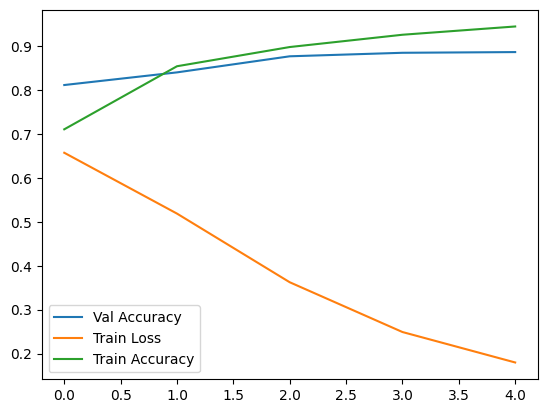

In [37]:
plt.plot(result['val_accuracy'], label='Val Accuracy')
plt.plot(result['loss'], label='Train Loss')
plt.plot(result['accuracy'], label='Train Accuracy')
plt.legend()
plt.plot()

In [38]:
model.evaluate(X_val, Y_val)

157/157 [==============================] - 1s 4ms/step - loss: 0.2796 - accuracy: 0.8864


[0.27960726618766785, 0.8863999843597412]

# Testing

In [49]:
test = pd.read_csv('Test.csv')

In [50]:
test.shape

(10000, 1)

In [51]:
test.head()

,review
0,Remember those old kung fu movies we used to w...
1,This movie is another one on my List of Movies...
2,How in the world does a thing like this get in...
3,"""Queen of the Damned"" is one of the best vampi..."
4,The Caprica episode (S01E01) is well done as a...


In [52]:
test['cleaned_review'] = test['review'].apply(clean_text)

In [53]:
X_test = test['cleaned_review']

In [54]:
X_test = cv.transform(X_test)

In [55]:
X_test.shape

(10000, 42314)

In [56]:
X_test = tfidf.transform(X_test)

In [47]:
X_test = X_test.toarray()

In [58]:
Y_pred = model.predict(X_test)

InvalidArgumentError: ignored

In [ ]:
Y_pred

In [ ]:
Y_pred = [1 if y>0.5 else 0 for y in Y_pred]

In [ ]:
Y_pred

# Saving the model

In [39]:
model.save('model.h5')

# Load model

In [40]:
from keras.models import load_model
loaded_model = load_model('model.h5')

In [41]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                677040    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 677,329
Trainable params: 677,329
Non-trainable params: 0
_________________________________________________________________


# Try your own input

In [105]:
def custom_predict(testing_data):
  testing_data = [clean_text(testing_data)]
  td = cv.transform(testing_data)
  td = tfidf.transform(td)
  td = td.toarray()
  if model.predict(td)>0.5:
    return 'Positive'
  else:
    return 'negative'

In [106]:
custom_predict("breathtaking and astounding movie and i was left flabbergasted")

1/1 [==============================] - 0s 20ms/step


'Positive'